In [1]:
from math import floor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import TimeSeriesSplit


from sklearn import tree
import datetime as datetime


import quandl as ql
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib
import smabt

from talib import MACD

from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

In [2]:
ds_currency = xr.open_zarr('currency_pairs')

In [3]:
df_currency = ds_currency.to_dataframe().unstack(level=1)
df_currency.columns = df_currency.columns.droplevel(0)
df_currency = df_currency.rename_axis(None, axis=1)
df_currency.tail()

,aus_usd,cad_usd,eur_usd,jpy_usd,usd_gbp
Date,,,,,
2019-01-07,0.7143,1.3297,1.1468,108.62,1.2757
2019-01-08,0.7134,1.3307,1.1444,108.57,1.2724
2019-01-09,0.7172,1.3212,1.1524,108.38,1.2764
2019-01-10,0.7190,1.3232,1.1517,108.29,1.2768
2019-01-11,0.7204,1.3256,1.1479,108.34,1.2836


#### Moving Average Crossover
+ Create two series of moving averages based on different windows
+ If shorter period average is higher than the longer period average it indicates bullish trend
+ If shorter period average is lower than longer period average it indicates bearish trend
+ You can adjust the windows to get a better sense of false positives
+ You can also create a 'confirmation' indicator to further filter out false positives

In [4]:
def compute_moving_average_trend_signal(period_df,period_1=21, period_2=120):
    '''
    Computes moving averages used in ma crossover factor
    
    Parameters
    ==========
    period_df: pd.Dataframe
    period_1: int
    period_2: int
    
    Returns
    =======
    pd.Dataframe of price and moving averages for two specified periods 
    '''
    #dfs = []
    #for pair in period_df.columns:

    sma_period1 = period_df.rolling(period_1).mean() 

    sma_period2 = period_df.rolling(period_2).mean() 

    ma_signal = pd.Series(np.where(sma_period1 > sma_period2, 1, -1), index=period_df.index)
       # dfs.append(new_df)
    ctd_df = pd.concat([sma_period1, sma_period2, ma_signal, period_df], axis=1)
    ctd_df.columns = ['sma1', 'sma2', 'signal', 'price']
    return ctd_df

In [5]:
df_currency['eur_usd'].head()

Date
2008-01-02    1.4738
2008-01-03    1.4736
2008-01-04    1.4786
2008-01-07    1.4684
2008-01-08    1.4717
Name: eur_usd, dtype: float64

In [6]:
signal_df = compute_moving_average_trend_signal(df_currency['eur_usd'])

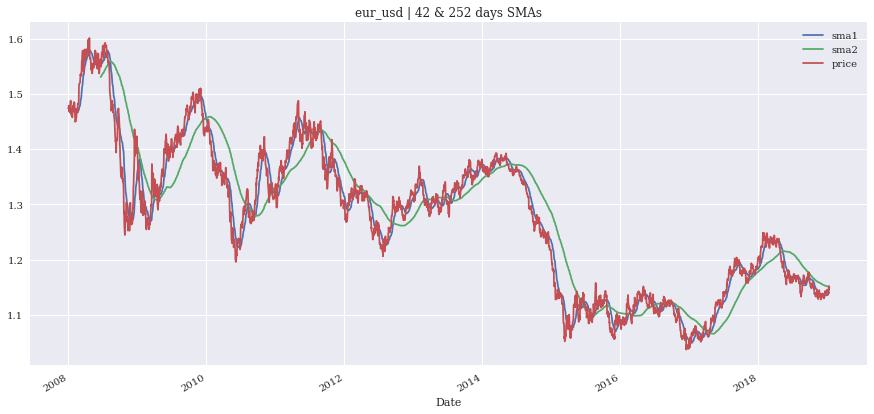

In [7]:
#signal_df = df_currency.dropna()

signal_df[['sma1', 'sma2', 'price']].plot(title='eur_usd | 42 & 252 days SMAs',
                   figsize=(15, 7));


#### Set a condition for the trade position
+ Set position value to 1 if sma1 is greater than sma2
+ Set position value to -1 if sma1 is less than sma2

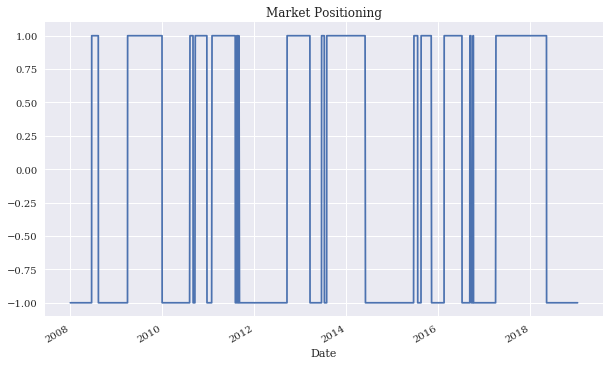

In [8]:
signal_df['position'] = np.where(signal_df['sma1'] > signal_df['sma2'],
                                     1, -1)
signal_df['position'].plot(ylim=[-1.1, 1.1],
                               title='Market Positioning',
                               figsize=(10, 6));

#### Distribution of log returns for this pair

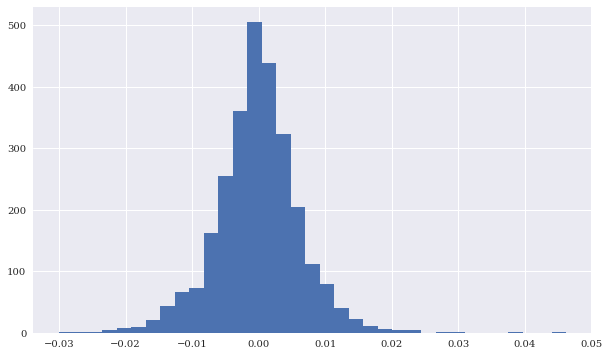

In [9]:
signal_df['returns'] = np.log(signal_df.price/signal_df.price.shift(1))
signal_df['returns'].hist(bins=35, figsize=(10, 6));

#### What does the profit profile look like if we trade this strategy
+ shift position column by one day to indicate our implied position for the next day
+ multiply our returns column by our position column to simulate what our strategy would have returned on that day

In [10]:
signal_df['strategy'] = signal_df['position'].shift(1) * signal_df['returns']

In [11]:
signal_df[['returns', 'strategy']].sum()

returns    -0.24991
strategy    0.27711
dtype: float64

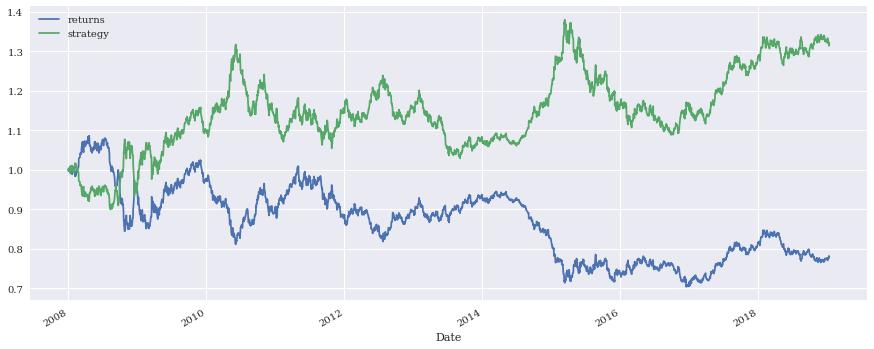

In [12]:
signal_df[['returns', 'strategy']].dropna().cumsum(
                     ).apply(np.exp).plot(figsize=(15, 6))

## Summary Statistics

##### Annualized Mean Return

In [13]:
signal_df[['returns', 'strategy']].mean()* 252

returns    -0.022785
strategy    0.025265
dtype: float64

##### Annualized Standard Deviation

In [14]:
signal_df[['returns', 'strategy']].std() * 252 ** 0.5

returns     0.101128
strategy    0.101125
dtype: float64

##### Compute cumulative Return

In [15]:
signal_df['cumret'] = signal_df['strategy'].cumsum().apply(np.exp)

##### Compute cumulative max

In [16]:
signal_df['cummax'] =  signal_df['cumret'].cummax()

##### Compute the max drawdown

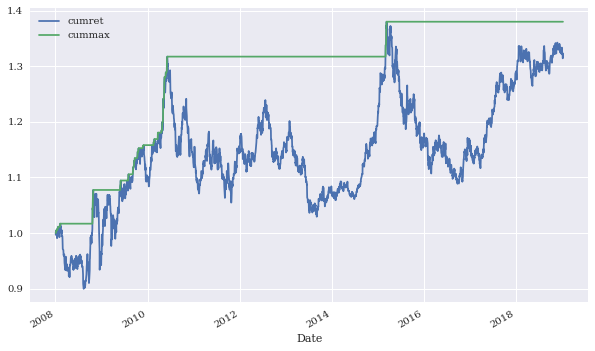

In [17]:
signal_df[['cumret', 'cummax']].dropna().plot(figsize=(10, 6))

In [18]:
drawdown = signal_df['cummax'] - signal_df['cumret'] 

In [19]:
drawdown.max()

0.29150902644023335

##### Compute max duration of drawdown

In [20]:
#find the dates where drawdown is equal to 0
#these are the moments when our cumulative returns and the max cumulative returns are the same
temp = drawdown[drawdown == 0]

In [21]:
#compute the time difference between each of these moments in time

periods = (temp.index[1:].to_pydatetime() -
                    temp.index[:-1].to_pydatetime())

In [22]:
#find the max duration of time
periods.max()  

datetime.timedelta(1732)

##### Vectorized Backtesting
+ The SMAVectorBacktester allows us to instantiate a class and test our strategy
+ We can cycle through a sequence of sma periods and optimize based on the performance of a given pair
+ I've taken the basic architecture for the class from Yves Hiplisch. 
+ However, I added a parameter to keep track sma values that outperformed above some threshold
+ My intent is to do some analysis on those values for each currency pair
+ For each currency pair there is a clear set of parameter that make sense visually
+ It would be a good analysis to track this changing through time to see if we can get a dynamic value
+ For example, let's say we can ballpark our sma values and we can say that is our current regime
+ As we move through time, is there a way to update those sma values to land on the the values with the best 
performance. 




In [63]:
jpy_usd = smabt.SMAVectorBacktester(df_currency,'jpy_usd', 42, 252, '2008-01-02','2019-01-11')
jpy_usd.run_strategy()

(0.92, -0.27)

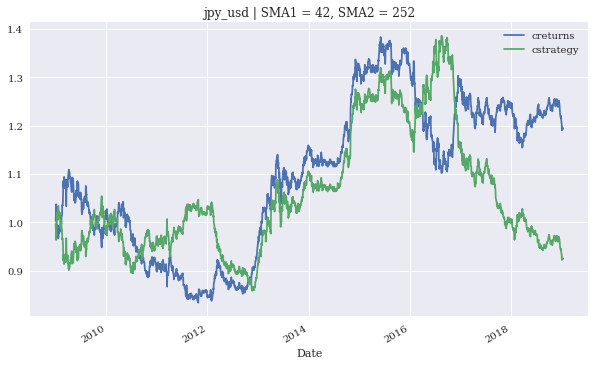

In [64]:
jpy_usd.plot_results()

In [59]:
eur_usd = smabt.SMAVectorBacktester(df_currency,'eur_usd', 42, 252, '2008-01-02','2019-01-11')
eur_usd.run_strategy()

(1.17, 0.35)

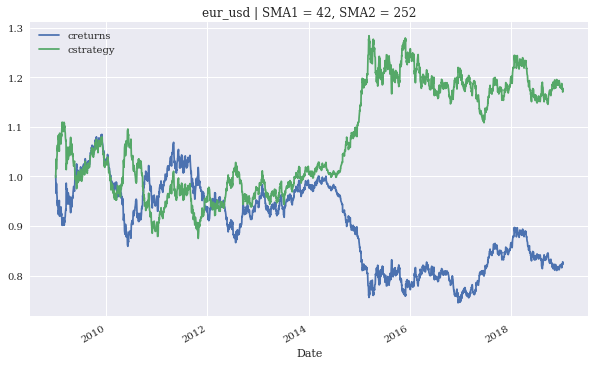

In [60]:
eur_usd.plot_results()

In [56]:
eur_usd.optimize_parameters((10,50,2), (70,150,2))

(array([ 42., 128.]), 1.95)

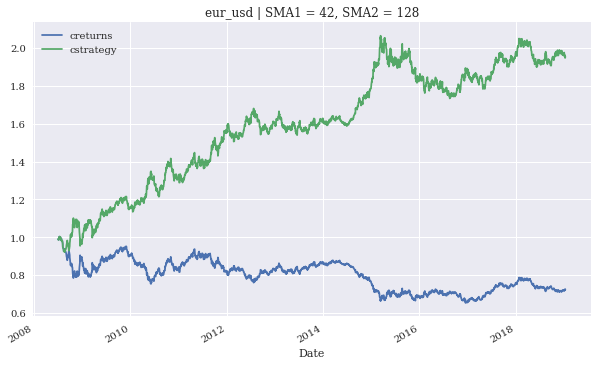

In [52]:
eur_usd.plot_results()

In [66]:
aus_usd = smabt.SMAVectorBacktester(df_currency, 'aus_usd',42, 252, '2008-01-02','2019-01-11' )

In [67]:
aus_usd.run_strategy()

(0.66, -0.37)

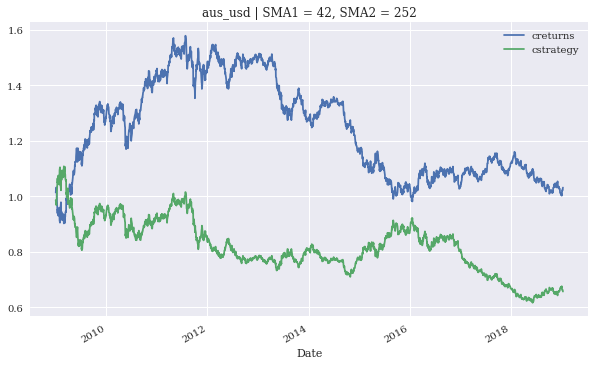

In [68]:
aus_usd.plot_results()

In [72]:
usd_gbp = smabt.SMAVectorBacktester(df_currency, 'usd_gbp', 42, 252, '2008-01-02','2019-01-11')

In [73]:
usd_gbp.run_strategy()


(0.84, -0.04)

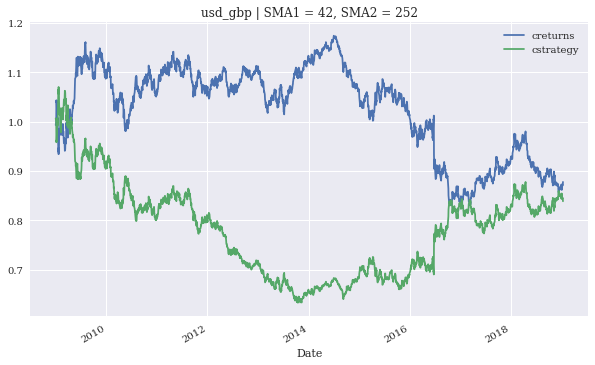

In [74]:
usd_gbp.plot_results()

In [76]:
cad_usd = smabt.SMAVectorBacktester(df_currency, 'cad_usd', 42, 252, '2008-01-02','2019-01-11')

In [77]:
cad_usd.run_strategy()

(1.05, -0.04)

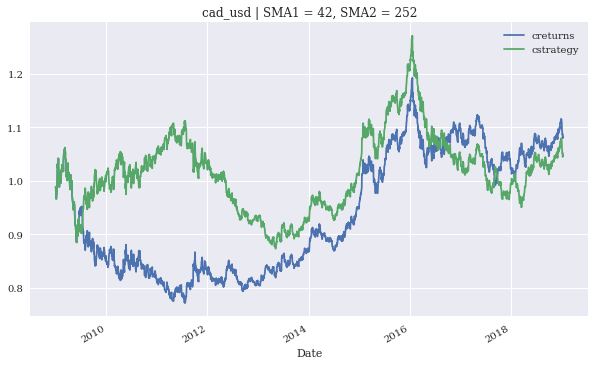

In [78]:
cad_usd.plot_results()

#### Currency Pair breakdown
+ We can see that each pair, for the period under consideration, responds totally different to the values selected
+ Some pairs exhibit strong performance and others weak


In [80]:
aus_usd.optimize_parameters((10,50,2), (50,150,2))

(array([40., 50.]), 2.04)

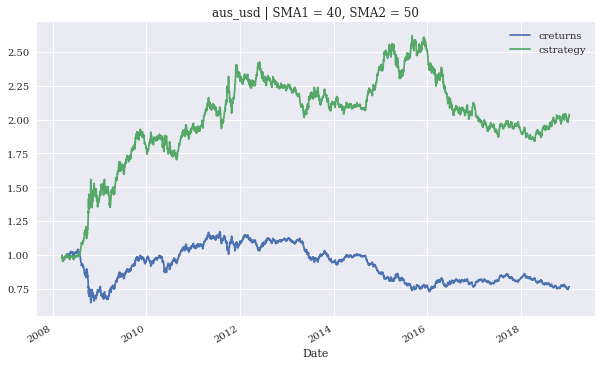

In [82]:
aus_usd.plot_results()